# Import

In [1]:
import pandas as pd
import datetime
from isoduration import parse_duration
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold

# Constants

In [2]:
REVIEWS_DATA = "../dataset/reviews.parquet"
RECIPES_DATA = "../dataset/recipes.parquet"

In [3]:
INDEX_TO_RECIPE_OBJ = "../EDA_files/index_to_recipe.obj"
RECIPE_TO_INDEX_OBJ = "../EDA_files/recipe_to_index.obj"
RECIPES_SMALL = "../EDA_files/recipes_small.parquet"
RATINGS_SMALL = "../EDA_files/ratings_small.parquet"
REVIEWS_PER_RECIPE_WITH_0 = "../EDA_files/reviews_per_recipe_with_0.obj"
REVIEWS_PER_RECIPE_WITHOUT_0 = "../EDA_files/reviews_per_recipe_without_0.obj"
REVIEWS_PER_USER_WITH_0 = "../EDA_files/reviews_per_user_with_0.obj"
REVIEWS_PER_USER_WITHOUT_0 = "../EDA_files/reviews_per_user_without_0.obj"
RATINGS_TIME = "../EDA_files/ratings_time.parquet"

RECIPE_ID_TO_NAME = "../EDA_files/recipe_id_to_name.obj"
RECIPE_ID_TO_CAT = "../EDA_files/recipe_id_to_category.obj"

# Load data

In [4]:
ratings = pd.read_parquet(REVIEWS_DATA)

In [5]:
recipes = pd.read_parquet(RECIPES_DATA)

In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   ReviewId       1401982 non-null  int32              
 1   RecipeId       1401982 non-null  int32              
 2   AuthorId       1401982 non-null  int32              
 3   AuthorName     1401982 non-null  object             
 4   Rating         1401982 non-null  int32              
 5   Review         1401982 non-null  object             
 6   DateSubmitted  1401982 non-null  datetime64[ns, UTC]
 7   DateModified   1401982 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int32(4), object(2)
memory usage: 64.2+ MB


In [7]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   RecipeId                    522517 non-null  float64            
 1   Name                        522517 non-null  object             
 2   AuthorId                    522517 non-null  int32              
 3   AuthorName                  522517 non-null  object             
 4   CookTime                    439972 non-null  object             
 5   PrepTime                    522517 non-null  object             
 6   TotalTime                   522517 non-null  object             
 7   DatePublished               522517 non-null  datetime64[ns, UTC]
 8   Description                 522512 non-null  object             
 9   Images                      522516 non-null  object             
 10  RecipeCategory              521766 non-null 

In [8]:
recipes["CookTime"].fillna("PT0M", inplace=True)
recipes["PrepTime"].fillna("PT0M", inplace=True)
recipes["TotalTime"].fillna("PT0M", inplace=True)

## Create recipes_small


In [9]:
def duration_to_minutes(duration):
    return float((duration.date.days * 1440) + (duration.time.hours * 60) + duration.time.minutes)

In [10]:
def create_recipes_subset():
    recipes_small = pd.DataFrame()
    recipes_small = recipes[["RecipeId", "Name", "AuthorId"]].copy()
    recipes_small["CookTimeInMinutes"] = recipes["CookTime"].copy()
    recipes_small["CookTimeInMinutes"] = recipes_small["CookTimeInMinutes"].apply(lambda x: duration_to_minutes(parse_duration(x)))
    recipes_small["PrepTimeInMinutes"] = recipes["PrepTime"].copy()
    recipes_small["PrepTimeInMinutes"] = recipes_small["PrepTimeInMinutes"].apply(lambda x: duration_to_minutes(parse_duration(x)))
    recipes_small["TotalTimeInMinutes"] = recipes["TotalTime"].copy()
    recipes_small["TotalTimeInMinutes"] = recipes_small["TotalTimeInMinutes"].apply(lambda x: duration_to_minutes(parse_duration(x)))
    recipes_small["DatePublished"] = recipes["DatePublished"].copy()
    recipes_small["Description"] = recipes["Description"].copy()
    recipes_small["RecipeCategory"] = recipes["RecipeCategory"].copy()

    recipes_small["Keywords"] = recipes["Keywords"].copy()
    recipes_small["Keywords"] = recipes_small["Keywords"].apply(lambda x: x.tolist())

    recipes_small["Ingredients"] = recipes["RecipeIngredientParts"].copy()
    recipes_small["Ingredients"] = recipes_small["Ingredients"].apply(lambda x: x.tolist())

    recipes_small["RecipeServings"] = recipes["RecipeServings"].copy()
    recipes_small["RecipeInstructions"] = recipes["RecipeInstructions"].copy()
    recipes_small['RecipeId'] = recipes_small['RecipeId'].apply(lambda x: int(x))
    
    return recipes_small

In [11]:
recipes_small = create_recipes_subset()

In [12]:
recipes_small['Nutritions'] = recipes[['FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']].values.tolist()

In [13]:
recipes_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   RecipeId            522517 non-null  int64              
 1   Name                522517 non-null  object             
 2   AuthorId            522517 non-null  int32              
 3   CookTimeInMinutes   522517 non-null  float64            
 4   PrepTimeInMinutes   522517 non-null  float64            
 5   TotalTimeInMinutes  522517 non-null  float64            
 6   DatePublished       522517 non-null  datetime64[ns, UTC]
 7   Description         522512 non-null  object             
 8   RecipeCategory      521766 non-null  object             
 9   Keywords            522517 non-null  object             
 10  Ingredients         522517 non-null  object             
 11  RecipeServings      339606 non-null  float64            
 12  RecipeInstructio

### Create <i>index_to_recipe</i> and <i>recipe_to_index</i>

In [14]:
index_to_recipe_df = pd.DataFrame(recipes_small['RecipeId'])

In [15]:
recipe_to_index_df = index_to_recipe_df.reset_index(inplace=False)
recipe_to_index_df.set_index('RecipeId', inplace=True)

In [16]:
temp = index_to_recipe_df.to_dict('index')
index_to_recipe = {key: value['RecipeId'] for key, value in temp.items()}

In [17]:
temp = recipe_to_index_df.to_dict('index')
recipe_to_index = {key: value['index'] for key, value in temp.items()}

In [18]:
recipe_id_to_name_df = pd.DataFrame(recipes_small[['RecipeId', 'Name']])
recipe_id_to_name_df = recipe_id_to_name_df.reset_index(inplace=False)
recipe_id_to_name_df.set_index('RecipeId', inplace=True)
recipe_id_to_name_df.drop(columns=['index'], inplace=True)

temp = recipe_id_to_name_df.to_dict('index')
recipe_id_to_name = {key: value['Name'] for key, value in temp.items()}

In [19]:
recipe_id_to_cat_df = pd.DataFrame(recipes_small[['RecipeId', 'RecipeCategory']])
recipe_id_to_cat_df = recipe_id_to_cat_df.reset_index(inplace=False)
recipe_id_to_cat_df.set_index('RecipeId', inplace=True)
recipe_id_to_cat_df.drop(columns=['index'], inplace=True)

temp = recipe_id_to_cat_df.to_dict('index')
recipe_id_to_cat = {key: value['RecipeCategory'] for key, value in temp.items()}

## Create ratings_small

In [20]:
ratings_small = pd.DataFrame()
ratings_small = ratings[['RecipeId', 'AuthorId', 'Rating', 'Review', 'DateSubmitted']].copy()

In [21]:
# delete ratings of missing recipes
missing_recipes = ratings_small[~ratings_small.RecipeId.isin(recipes.RecipeId)]
ratings_small = ratings_small.drop(missing_recipes.index)

In [22]:
print('Number of reviewed recipes: ', ratings_small['RecipeId'].nunique())
print('Number of users: ', ratings_small['AuthorId'].nunique())

Number of reviewed recipes:  271674
Number of users:  271906


### Get number of reviews per recipe and user

In [23]:
def avg_rating(df, per_col, value):
    return ratings_small[(df[per_col]==value) & (df['Rating']!=0)]['Rating'].mean()

### Recipe

In [24]:
reviews_per_recipe_with_0 = ratings_small.groupby('RecipeId').agg({"RecipeId": 'count', "Rating": "mean"})
reviews_per_recipe_with_0 = reviews_per_recipe_with_0.rename(columns={'RecipeId': "ReviewsPerRecipe", 'Rating': "AvgRating"})

In [25]:
reviews_per_recipe_without_0 = ratings_small[ratings_small['Rating']!=0].groupby('RecipeId').agg({"RecipeId": 'count', "Rating": "mean"})
reviews_per_recipe_without_0 = reviews_per_recipe_without_0.rename(columns={'RecipeId': "ReviewsPerRecipe", 'Rating': "AvgRating"})

In [26]:
print("Number of unique recipes excluding 0 ratings: ", reviews_per_recipe_without_0.shape[0])
print("Number of unique recipes including 0 ratings: ", reviews_per_recipe_with_0.shape[0])

Number of unique recipes excluding 0 ratings:  265812
Number of unique recipes including 0 ratings:  271674


### User

In [27]:
reviews_per_user_with_0 = ratings_small.groupby('AuthorId').agg({"AuthorId": 'count', "Rating": "mean"})
reviews_per_user_with_0 = reviews_per_user_with_0.rename(columns={'AuthorId': "ReviewsPerUser", 'Rating': "AvgRating"})

In [28]:
reviews_per_user_without_0 = ratings_small[ratings_small['Rating']!=0].groupby('AuthorId').agg({"AuthorId": 'count', "Rating": "mean"})
reviews_per_user_without_0 = reviews_per_user_without_0.rename(columns={'AuthorId': "ReviewsPerUser", 'Rating': "AvgRating"})

In [29]:
print("Number of unique users excluding 0 ratings: ", reviews_per_user_without_0.shape[0])
print("Number of unique users including 0 ratings: ", reviews_per_user_with_0.shape[0])

Number of unique users excluding 0 ratings:  234634
Number of unique users including 0 ratings:  271906


### Create recipes with ratings sample 

In [30]:
recipes_with_ratings = recipes_small[recipes_small.RecipeId.isin(ratings_small.RecipeId)]

In [31]:
index_to_recipe_df = pd.DataFrame(recipes_with_ratings['RecipeId'])
recipe_to_index_df = index_to_recipe_df.reset_index(inplace=False)

recipe_to_index_df.set_index('RecipeId', inplace=True)

temp = index_to_recipe_df.to_dict('index')
index_to_recipe_with_ratings = {key: value['RecipeId'] for key, value in temp.items()}

temp = recipe_to_index_df.to_dict('index')
recipe_to_index_with_ratings = {key: value['index'] for key, value in temp.items()}

# Histograms

## Liczba ocen

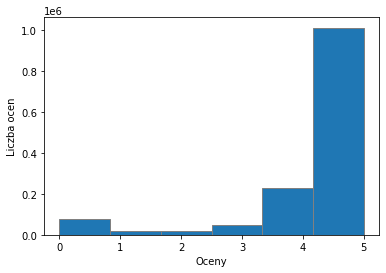

In [30]:
plt.hist(ratings_small['Rating'], bins=6, edgecolor='gray')
plt.xlabel("Oceny")
plt.ylabel("Liczba ocen")
plt.show()

## Liczba ocen / użytkownik

In [31]:
reviews_per_user_sorted = reviews_per_user_with_0.sort_values(by='ReviewsPerUser', ascending=False)

In [32]:
y = reviews_per_user_sorted[reviews_per_user_sorted['ReviewsPerUser']>1]
y = y['ReviewsPerUser'].tolist()

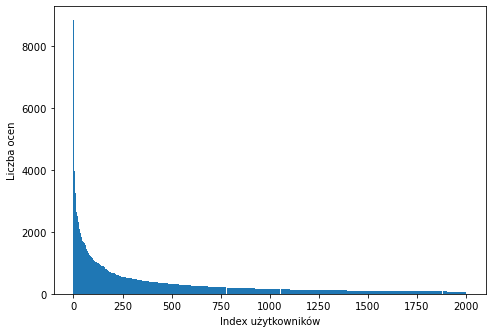

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ids = range(0, len(y))
counts = y
ax.bar(ids[:2000], counts[:2000], width=1.0)
ax.set_ylabel("Liczba ocen")
ax.set_xlabel("Index użytkowników")
plt.show()

## Liczba ocen / przepis

In [34]:
reviews_per_recipe_sorted = reviews_per_recipe_with_0.sort_values(by='ReviewsPerRecipe', ascending=False)
y = reviews_per_recipe_sorted[reviews_per_recipe_sorted['ReviewsPerRecipe']>1]
y = y['ReviewsPerRecipe'].tolist()

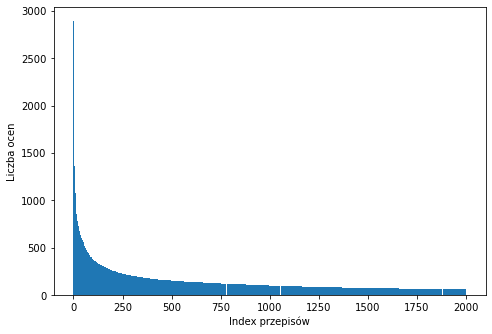

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ids = range(0, len(y))
counts = y
ax.bar(ids[:2000], counts[:2000], width=1.0)
ax.set_ylabel("Liczba ocen")
ax.set_xlabel("Index przepisów")
plt.show()

"Long tail problem" - większość itemów w systemie jest oceniona tylko przez kilku użytkowników. Większość użytkowników ma zaledwie kilka ocen.

# Czas

In [36]:
ratings_time = ratings_small.copy()

In [37]:
ratings_time['Month'] = ratings_time['DateSubmitted'].apply(lambda x: x.month)
ratings_time['Year'] = ratings_time['DateSubmitted'].apply(lambda x: x.year)
ratings_time['DayOfWeek'] = ratings_time['DateSubmitted'].apply(lambda x: x.weekday)
ratings_time['IsWeekend'] = ratings_time['DayOfWeek'].apply(lambda x: x > 5)
ratings_time['Quarter'] = ratings_time['DateSubmitted'].apply(lambda x: x.quarter)

In [38]:
ratings_per_month = ratings_time.groupby('Month').agg({'Month': 'count'})
ratings_per_month = ratings_per_month.rename(columns={'Month': 'Count'})

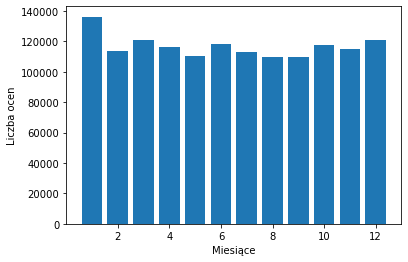

In [39]:
plt.bar(ratings_per_month.index, ratings_per_month['Count'])
plt.xlabel('Miesiące')
plt.ylabel('Liczba ocen')
plt.show()

In [40]:
month_counts = ratings_time.groupby(['Month']).agg({'Month':'count'})
ratings_per_month = ratings_time[ratings_time['Rating']>0].groupby(['Month', 'Rating']).agg({'Month': 'count'})
ratings_per_month = ratings_per_month.rename(columns={'Month': 'Counts'})

In [41]:
x = ratings_per_month.loc[1].index.tolist()
y = ratings_per_month.loc[1]["Counts"].tolist()
y = np.array(y) / sum(y)

In [42]:
ratings_time

,RecipeId,AuthorId,Rating,Review,DateSubmitted,Month,Year,DayOfWeek,IsWeekend,Quarter
0,992,2008,5,better than any you can get at a restaurant!,2000-01-25 21:44:00+00:00,1,2000,1,False,1
1,4384,1634,4,"I cut back on the mayo, and made up the differ...",2001-10-17 16:49:59+00:00,10,2001,2,False,4
2,4523,2046,2,i think i did something wrong because i could ...,2000-02-25 09:00:00+00:00,2,2000,4,False,1
3,7435,1773,5,easily the best i have ever had. juicy flavor...,2000-03-13 21:15:00+00:00,3,2000,0,False,1
4,44,2085,5,An excellent dish.,2000-03-28 12:51:00+00:00,3,2000,1,False,1
...,...,...,...,...,...,...,...,...,...,...
1401977,139499,2002080368,2,I was disappointed. I couldn't wait to make th...,2020-12-27 23:57:54+00:00,12,2020,6,True,4
1401978,148484,41805321,5,Nothing to drain. And I don’t heat up the liqu...,2020-12-28 00:44:42+00:00,12,2020,0,False,4
1401979,264191,2002901848,5,Good base recipe for someone to start with. I ...,2020-12-28 01:04:43+00:00,12,2020,0,False,4
1401980,411791,2002901938,5,Thank you so much for this amazing recipe! I l...,2020-12-28 03:07:10+00:00,12,2020,0,False,4


(0.0, 100.0)

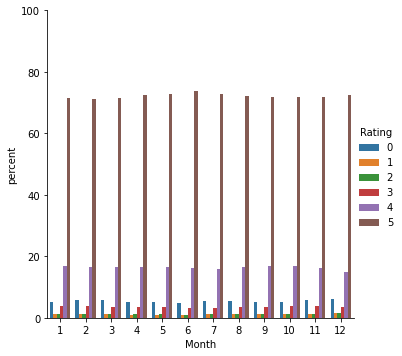

In [43]:
x,y = 'Month', 'Rating'

df1 = ratings_time.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)


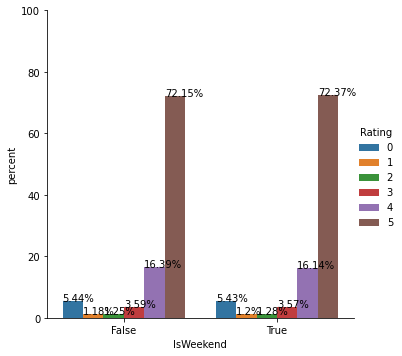

In [44]:
x,y = 'IsWeekend', 'Rating'

df1 = ratings_time.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

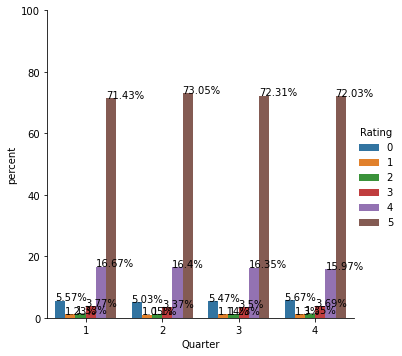

In [45]:
x,y = 'Quarter', 'Rating'

df1 = ratings_time.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Rozkład ocen jest taki sam dla różnych przedziałów czasu, więc taka informacja raczej nie będzie miała wpływu na oceny. 

# Categories

In [56]:
for counts, values in recipes_small.RecipeCategory.value_counts().items():
    print(counts, values)

Dessert 62072
Lunch/Snacks 32586
One Dish Meal 31345
Vegetable 27231
Breakfast 21101
Beverages 16076
Chicken 13249
Meat 13131
Breads 12804
Pork 12603
Sauces 12166
Chicken Breast 11282
Potato 10870
Quick Breads 10387
< 60 Mins 9719
< 30 Mins 9020
Cheese 8462
Pie 7775
Bar Cookie 7029
Low Protein 6663
< 15 Mins 6662
Drop Cookies 6385
Stew 5679
Yeast Breads 5523
Beans 5463
Candy 5229
Salad Dressings 5066
< 4 Hours 4969
Frozen Desserts 4804
Spreads 4694
Poultry 3925
Cheesecake 3915
Low Cholesterol 3807
European 3690
Smoothies 3562
Very Low Carbs 3386
Steak 3242
Onions 3177
Savory Pies 3055
Curries 2828
Rice 2735
Fruit 2568
Chowders 2331
Grains 2280
Corn 2274
Yam/Sweet Potato 2238
Asian 2196
Crab 2171
Punch Beverage 2169
Mexican 2119
Lamb/Sheep 2050
Spinach 1960
Spaghetti 1865
Chicken Thigh & Leg 1739
Healthy 1720
Ham 1614
Roast Beef 1522
Greens 1514
Whole Chicken 1475
Clear Soup 1474
Tarts 1456
Gelatin 1435
Tuna 1413
Peppers 1412
Cauliflower 1398
Weeknight 1337
Black Beans 1325
Apple 1287
S

# Save data

In [60]:
import pickle
# with open(INDEX_TO_RECIPE_OBJ, 'wb') as pickle_file:
#      pickle.dump(index_to_recipe, pickle_file)
# with open(RECIPE_ID_TO_NAME, 'wb') as pickle_file:
#      pickle.dump(recipe_id_to_name, pickle_file)
# with open(RECIPE_ID_TO_CAT, 'wb') as pickle_file:
#      pickle.dump(recipe_id_to_cat, pickle_file)
# with open(RECIPE_TO_INDEX_OBJ, 'wb') as pickle_file:
#      pickle.dump(recipe_to_index, pickle_file)
# with open(REVIEWS_PER_RECIPE_WITH_0, 'wb') as pickle_file:
#      pickle.dump(reviews_per_recipe_with_0, pickle_file)
# with open(REVIEWS_PER_RECIPE_WITHOUT_0, 'wb') as pickle_file:
#      pickle.dump(reviews_per_recipe_without_0, pickle_file)
# with open(REVIEWS_PER_USER_WITH_0, 'wb') as pickle_file:
#      pickle.dump(reviews_per_user_with_0, pickle_file)
# with open(REVIEWS_PER_USER_WITHOUT_0, 'wb') as pickle_file:
#      pickle.dump(reviews_per_user_without_0, pickle_file)
# recipes_small.to_parquet(RECIPES_SMALL)
# ratings_small.to_parquet(RATINGS_SMALL)
# ratings_time.to_parquet(RATINGS_TIME)

In [32]:

# recipes_with_ratings.to_parquet("../samples/recipes_with_ratings.parquet")      
# with open("../samples/index_to_recipe_with_ratings.obj", 'wb') as pickle_file:
#      pickle.dump(index_to_recipe_with_ratings, pickle_file)
        
# with open("../samples/recipe_to_index_with_ratings.obj", 'wb') as pickle_file:
#      pickle.dump(recipe_to_index_with_ratings, pickle_file)